<a href="https://colab.research.google.com/github/Sai-Pranav2503/Inductions-22/blob/Sai-Pranav2503-patch-2/DataByte_CNN_ImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

In [ ]:
pd.set_option("display.precision", 8)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
dataset='/content/drive/My Drive/Avengers_Images'

Mounted at /content/drive


In [ ]:
Img_dim = (224, 224)
train_dir = str(dataset)
print(train_dir)
datagenArgs = dict(rescale=1./255, validation_split=.20)
datagenArgs
validation_gen = tf.keras.preprocessing.image.ImageDataGenerator(**datagenArgs)
gen_valid = validation_gen.flow_from_directory(
    train_dir,
    subset = "validation",
    shuffle = True,
    target_size =Img_dim
)
training_gen = tf.keras.preprocessing.image.ImageDataGenerator(**datagenArgs)
gen_train  = training_gen.flow_from_directory(
    train_dir,
    subset = "training",
    shuffle = True,
    target_size =Img_dim
)

/content/drive/My Drive/Avengers_Images
Found 145 images belonging to 5 classes.
Found 590 images belonging to 5 classes.


In [ ]:
TrainImg_batch, TrainLabel_batch = next(iter(gen_train))
print("Image batch shape: ", TrainImg_batch.shape)
print("Label batch shape: ", TrainLabel_batch.shape)
dataLabels = sorted(gen_train.class_indices.items(), key=lambda pair:pair[1])
dataLabels = np.array([key.title() for key, value in dataLabels])
print(dataLabels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)
['Black_Widow' 'Captain_America' 'Hulk' 'Iron_Man' 'Thor']


In [ ]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
    output_shape=[1280],
    trainable=False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(gen_train.num_classes, activation='softmax')
])
model
model.build([None, 224, 224, 3])
model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
train_epoch_steps = np.ceil(gen_train.samples/gen_train.batch_size)
val_epoch_steps = np.ceil(gen_valid.samples/gen_valid.batch_size)
print(train_epoch_steps)
print(val_epoch_steps)
hist = model.fit(
    gen_train,
    epochs=15,
    verbose=1,
    steps_per_epoch=train_epoch_steps,
    validation_data=gen_valid,
    validation_steps=val_epoch_steps).history

19.0
5.0
Epoch 1/15
19/19 [==============================] - 66s 4s/step - loss: 1.0461 - acc: 0.6220 - val_loss: 0.6616 - val_acc: 0.7655
Epoch 2/15
19/19 [==============================] - 12s 628ms/step - loss: 0.6983 - acc: 0.7492 - val_loss: 0.5179 - val_acc: 0.8276
Epoch 3/15
19/19 [==============================] - 11s 599ms/step - loss: 0.5709 - acc: 0.8102 - val_loss: 0.4322 - val_acc: 0.8621
Epoch 4/15
19/19 [==============================] - 11s 598ms/step - loss: 0.5080 - acc: 0.8271 - val_loss: 0.3904 - val_acc: 0.8552
Epoch 5/15
19/19 [==============================] - 12s 665ms/step - loss: 0.4248 - acc: 0.8525 - val_loss: 0.3442 - val_acc: 0.8759
Epoch 6/15
19/19 [==============================] - 11s 599ms/step - loss: 0.3549 - acc: 0.8881 - val_loss: 0.3182 - val_acc: 0.9241
Epoch 7/15
19/19 [==============================] - 12s 662ms/step - loss: 0.3061 - acc: 0.8966 - val_loss: 0.2804 - val_acc: 0.9034
Epoch 8/15
19/19 [==============================] - 11s 583ms/s

In [ ]:
model.save('saved_models/avengers')
avengers_model = tf.keras.models.load_model('saved_models/avengers')

ValImg_batch, ValLabel_batch = next(iter(gen_valid))
print("Validation batch shape:", ValImg_batch.shape)
true_label_ids = np.argmax(ValLabel_batch, axis=-1) 
print(true_label_ids)

Validation batch shape: (32, 224, 224, 3)
[3 2 2 3 4 4 3 2 4 4 2 0 4 0 4 2 1 3 1 2 2 0 0 3 0 0 0 0 2 0 3 0]


In [ ]:
ModelPred = avengers_model.predict(ValImg_batch)
Pred_Df = pd.DataFrame(ModelPred)
Pred_Df.columns = dataLabels
print("Prediction results for the first elements")
Pred_Df.head()

1/1 [==============================] - 0s 463ms/step
Prediction results for the first elements


,Black_Widow,Captain_America,Hulk,Iron_Man,Thor
0,0.00172664,0.00019287,0.00639380,0.98874193,0.00294479
1,0.00596731,0.01894545,0.96307760,0.00993737,0.00207231
2,0.01315327,0.04445205,0.85095906,0.08689451,0.00454118
3,0.00008178,0.00017731,0.00052699,0.99665242,0.00256147
4,0.00053673,0.03214425,0.00781672,0.02756217,0.93194008


In [ ]:
Pred_Ids = np.argmax(ModelPred, axis=-1)
print(Pred_Ids)
Pred_Labels = dataLabels[Pred_Ids]
print(Pred_Labels)

[3 2 2 3 4 4 3 2 4 4 2 0 4 0 4 2 1 3 1 2 2 0 0 3 0 0 0 0 2 0 3 0]
['Iron_Man' 'Hulk' 'Hulk' 'Iron_Man' 'Thor' 'Thor' 'Iron_Man' 'Hulk'
 'Thor' 'Thor' 'Hulk' 'Black_Widow' 'Thor' 'Black_Widow' 'Thor' 'Hulk'
 'Captain_America' 'Iron_Man' 'Captain_America' 'Hulk' 'Hulk'
 'Black_Widow' 'Black_Widow' 'Iron_Man' 'Black_Widow' 'Black_Widow'
 'Black_Widow' 'Black_Widow' 'Hulk' 'Black_Widow' 'Iron_Man' 'Black_Widow']


Text(0.5, 0.98, 'Model predictions (green: correct, red: incorrect)')

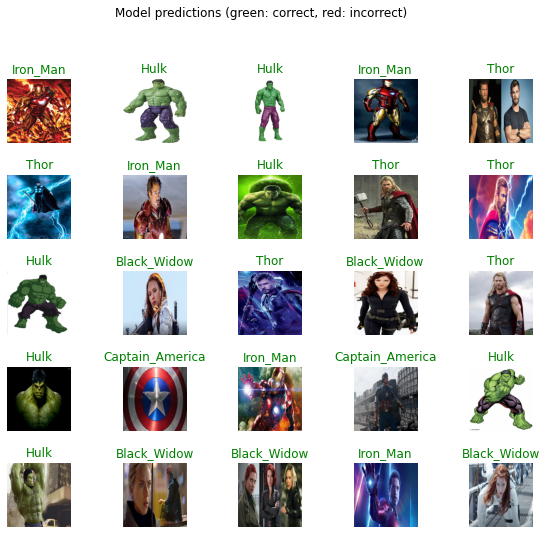

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)
for n in range(25):
  plt.subplot(6,5,n+1)
  plt.imshow(ValImg_batch[n])
  color = "green" if Pred_Ids[n] == true_label_ids[n] else "red"
  plt.title(Pred_Labels[n].title(), color=color)
  plt.axis('off')
plt.suptitle("Model predictions (green: correct, red: incorrect)")